In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# Importing the libraries

import IPython
import matplotlib.pyplot as plt
from scipy import ndimage
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb
import numpy as np
import xgboost as xgb
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error
from math import sqrt
import os
import numpy as np
import pandas as pd

# To disable annoying warnings 
import warnings

warnings.filterwarnings('ignore')


# Prophet model for time series forecast
from prophet import Prophet
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
# Multi-processing
from multiprocessing import Pool, cpu_count

# Process bar
from tqdm.notebook import tqdm
# Tracking time
from time import time

#!pip install neuralprophet
from neuralprophet import NeuralProphet

# Import models
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.kernel_ridge import KernelRidge

import sys

C:\Users\Tolis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [5]:
# Import from uploaded files 
base_dir = './dataset/'
#base_dir = '/content/drive/MyDrive/ShellBy AI/'

demand_history = pd.read_csv(base_dir + 'Demand_History.csv')
existing_ev = pd.read_csv(base_dir + 'exisiting_EV_infrastructure_2018.csv')
sample_sub = pd.read_csv(base_dir + 'sample_submission.csv')

prophet_forecasts = pd.read_csv(base_dir + 'prophet_2019_2020.csv')
prophet_18 = pd.read_csv(base_dir + 'prophet_2018.csv')


In [6]:
def demand_data_prep(demand_history: pd.DataFrame):
  demand_points_history = demand_history.drop(columns =['x_coordinate','y_coordinate'])
  demand_points_history = demand_points_history[['demand_point_index', '2010', '2011', '2012', '2013', '2014', '2015','2016', '2017']]
  demand_history_test = demand_points_history.T.iloc[1:,:]
  demand_points_ids=demand_history_test.columns.tolist()
  demand_history_test = demand_history_test.reset_index()
  demand_history_test = pd.melt(demand_history_test, id_vars ="index", value_vars =demand_points_ids )
  demand_history_test = demand_history_test.rename(columns = {"index":"ds","variable":"dp_id","value":"y"})
  return demand_history_test, demand_points_ids


In [71]:
def prophet_results(demand_history):
    demand_history_test, demand_points_ids = demand_data_prep(demand_history)
    groups_by_variable = demand_history_test.groupby('dp_id')
    # Multi-process Prophet Training 
    # Start time
    start_time = time()

    #TEST SECTION
    # Get time series data for each ticker and save in a list
    series = [groups_by_variable.get_group(ticker) for ticker in demand_points_ids]
    # Create a pool process with the number of worker processes being the number of CPUs
    p = Pool(cpu_count())
    # Make predictions for each ticker and save the results to a list
    predictions = list(tqdm(p.imap(train_and_forecast, series), total=len(series)))
    # Terminate the pool process
    p.close()
    # Tell the pool to wait till all the jobs are finished before exit
    p.join()
    # Concatenate results
    multiprocess_forecast = pd.concat(predictions)
    # Get the time used for the forecast
    print('\nThe time used for the multi-processing forecast is ', time()-start_time)
    # Save the results
    multiprocess_forecast.to_csv('prophet.csv', index=False)
    

In [9]:
# Train and Forecast for Prophet Model
def train_and_forecast(group):
  # Initiate the model
  m = Prophet()
  
  # Fit the model
  m.fit(group)
  # Make predictions
  future = m.make_future_dataframe(periods=2, freq='Y')
  forecast = m.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
  forecast['dp_id'] = group['dp_id'].iloc[0]
  
  # Return the forecasted results
  return forecast[['ds', 'dp_id', 'yhat', 'yhat_upper', 'yhat_lower']]

**Helper Function Implementation For the Prophet Implementation**

In [14]:
def get_preds(multiprocess_forecast, year=2018):
  ids = list(set(multiprocess_forecast.dp_id.tolist()))
  preds = []
  if year == 2018:
    for i in ids:
      preds.append(multiprocess_forecast[multiprocess_forecast['dp_id'] == ids[i]].iloc[8].yhat_upper)
  elif(year == 2019 or year == 2020):
    for i in ids:
      preds.append([multiprocess_forecast[multiprocess_forecast['dp_id'] == ids[i]].iloc[9].yhat_upper,multiprocess_forecast[multiprocess_forecast['dp_id'] == ids[i]].iloc[10].yhat_upper])
  return preds

In [ ]:
preds = get_preds(prophet_18, year=2018)

In [ ]:
proph_18 = pd.DataFrame(preds,columns=['preds'])

In [9]:
def prophet_preds_save(preds, year=2018):
  if year == 2018:
    preds_df = pd.concat([demand_history[['demand_point_index','2018']],pd.DataFrame(preds,columns=['prediction'])],axis=1)
    preds_df = preds_df.rename(columns ={"2018":"value"})
  elif(year == 2019 or year == 2020):
    preds_df = pd.concat([demand_history[['demand_point_index']],pd.DataFrame(preds,columns=['2019','2020'])],axis=1)
  preds_df.to_csv("predictions_2019_2020.csv",index=False)



In [ ]:
# Calculate RMSE to Validate 2018
rmse = sqrt(mean_squared_error(preds_df['value'], preds_df['prediction'])) 
print(f"RMSE: {rmse}")

# The sum of the mean absolute error of the demand
sum_of_mae = (preds_df['prediction']-preds_df['value']).abs().sum()
print(f"MAE: {sum_of_mae}")


mape = np.mean(np.abs((preds_df['value'] - preds_df['prediction']) / preds_df['value'])) * 100
print(f"MAPE: {mape}")

# Histogram of the Mean Absolute Error
plt.hist((preds_df['prediction']-preds_df['value']).abs(), bins = 25)
plt.show()

In [39]:
def dph_train_test_id(demand_history, mode = 'validate'):
  demand_point_idx_coords =  demand_history[['demand_point_index','x_coordinate','y_coordinate']]
  if mode == 'validate':
    demand_points_history_train = demand_history[['demand_point_index', '2010', '2011','2012', '2013', '2014', '2015', '2016', '2017']]
    demand_points_history_test = demand_history[['demand_point_index', '2018']]
  elif mode == 'train' :
    demand_points_history_train = demand_history[['demand_point_index', '2010', '2011','2012', '2013', '2014', '2015', '2016', '2017','2018']]
    demand_points_history_test = 0


  return demand_point_idx_coords, demand_points_history_train, demand_points_history_test
  




In [40]:
demand_point_idx_coords, demand_points_history_train, demand_points_history_test =  dph_train_test_id(demand_history, mode = 'validate')

In [41]:

'''
This helper function  transforms a demand point history row to column series
@ demand_points_hist: refers to the demand_points_history data frame
@ i: the row of the dataframe which is also equal to the demand point 
'''
def row_to_column_series(demand_points_hist, i):

    d_specific = demand_points_hist.loc[demand_points_hist['demand_point_index'] == i].T.reset_index().reset_index()
    demand_point_idx = d_specific.columns.tolist()[-1]
    d_specific= d_specific.rename(columns ={'level_0': 'demand_point_index' , 'index':'year', d_specific.columns.tolist()[-1] : 'demand'} )
    d_specific = d_specific.iloc[1:] 
    d_specific= d_specific.reset_index(drop= True)
    d_specific['demand_point_index'] = demand_point_idx

    return d_specific


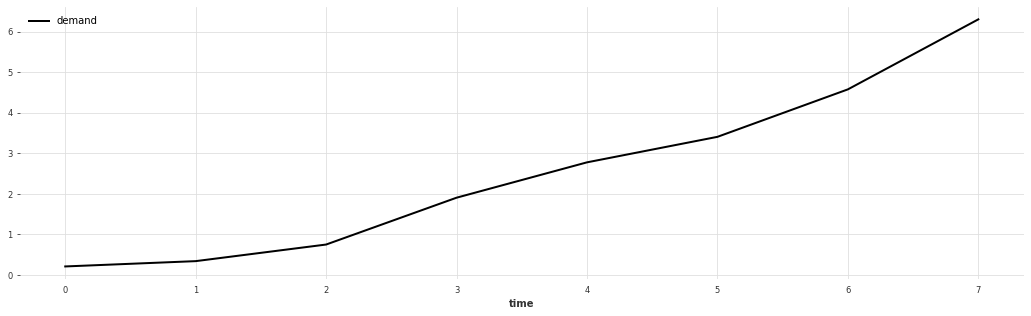

In [196]:
# plot the observations
plt.figure(100, figsize=(18, 5))
ts.plot();

In [58]:
'''
This function makes the forecast predictions
@ demand_points_hist: refers to the demand_points_history data frame
@ year: the year we are going to make the prediction
'''

def calculate_predictions(demand_points_hist, mode='NeuralProphet', year = '2018'):
  results = []
  DEMAND_POINTS = demand_points_hist['demand_point_index'].tolist()


  for i in tqdm(DEMAND_POINTS):

    d_specific = row_to_column_series(demand_points_hist, i)

    X = np.array(d_specific['year']).reshape(-1,1).astype(int)
    y = np.array(d_specific['demand'])


    if mode == "XGBoost":

      params = {
      # Parameters that we are going to tune.
      'max_depth':6,
      'n_estimators': 100,
      'eta':.3,
      'subsample': 1,
      'colsample_bytree': 1,
      }
      model = xgb.XGBRegressor(**params,objective ='reg:linear', verbosity = 0, random_state=42)
      model.fit(X, y)
      val = np.array([[year]],dtype="object")
      preds = model.predict(val)
      results.append(preds[0])

    elif mode =='NeuralProphet':
      print(f'###################### Number of Point {i} ###################### ')
      d_specific = row_to_column_series(demand_points_hist, i)
      d_specific = d_specific[['year','demand']].rename(columns={'year':'ds','demand':'y'})
      if sum(d_specific.y) == 0:
        results.append(0)
      else:
        #m = NeuralProphet(weekly_seasonality=False, epochs = 100)
        
        m = NeuralProphet(growth='linear',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    batch_size=2,
    epochs=10,
    learning_rate=.5
    )
        metrics = m.fit(d_specific, freq='Y')
        future = m.make_future_dataframe(d_specific, periods=2)
        forecast = m.predict(future)
        print(forecast)
        if year == 2018:
            results.append(forecast.iloc[0].yhat1)
        else:
            print([forecast.iloc[0].yhat1,forecast.iloc[1].yhat1])
            results.append([forecast.iloc[0].yhat1,forecast.iloc[1].yhat1])
            
    elif mode =='KR':
        model = KernelRidge(alpha=10.0)
        model.fit(X,y)
        val = np.array([[year]],dtype="object")
        preds = model.predict(val)
        results.append(preds[0])
        
    elif mode == 'LG':
        model = LinearRegression()
        model.fit(X, y)
        val = np.array([[year]],dtype="object")
        preds = model.predict(val)
        results.append(preds[0])
        
    elif mode == 'Logistic':
        model = LogisticRegression(solver='liblinear')
        model.fit(X,y)
        preds = model.predict(val)
        results.append(preds[0])
        
    
    elif mode =='LightGBM':
      # LightGBM
      params = {
      'boosting_type': 'gbdt',
      'objective': 'regression',
      'metric': {'l2', 'l1'},
      'num_leaves': 20,
      'learning_rate': 0.4,
      'feature_fraction': 0.9,
      'bagging_fraction': 0.8,
      'bagging_freq': 5,
      'verbose': 0
      }

      lgb_train = lgb.Dataset(X, y)
      # train
      model = lgb.train(params,lgb_train,num_boost_round=100)
      val = np.array([[year]],dtype="int")
      preds = model.predict(val)
      results.append(preds[0])

    elif mode == 'SARIMAX':
      # SARIMAX
      model = SARIMAX(y)
      model_fit = model.fit()
      # make prediction
      results.append(model_fit.forecast()[0])
    
    elif mode =='Poly':
      #Using a Simple Polynomial Regressor
      poly = PolynomialFeatures(degree=5, include_bias=False)
      x_ = poly.fit_transform(X)
      model = LinearRegression().fit(x_, y)
      val = np.array([[year]],dtype="object")
      preds = model.predict(poly.fit_transform(val))
      results.append(preds[0])
    # # MAE: 87297


  return results

In [59]:
demand_point_idx_coords, demand_points_history_train, demand_points_history_test =  dph_train_test_id(demand_history, mode = 'validate')

In [72]:
%%capture
res = calculate_predictions(demand_points_history_train, mode='NeuralProphet', year=2019) 

RMSE: 21.246813208409666
MAE: 63711.683339898154
MAPE: 21.234721787777495


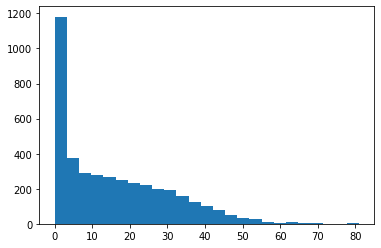

In [45]:
'''
 
Validate the model with 2018 as the forecast year
 
'''

# Merge the predictions with the true values
demand_evaluate = pd.merge(demand_predictions,demand_points_history_test[['demand_point_index','2018']],on='demand_point_index', how='left')
# Calculate RMSE
rmse = sqrt(mean_squared_error(demand_evaluate['2018'], demand_evaluate.preds)) 
print(f"RMSE: {rmse}")

# The sum of the mean absolute error of the demand
sum_of_mae = (demand_evaluate['preds']-demand_evaluate['2018']).abs().sum()
print(f"MAE: {sum_of_mae}")

mape = np.mean(np.abs((demand_evaluate['2018'] - demand_evaluate['preds']) / demand_evaluate['2018'])) * 100
print(f"MAPE: {mape}")

# Histogram of the Mean Absolute Error
plt.hist((demand_evaluate['preds']-demand_evaluate['2018']).abs(), bins = 25)
plt.show()

In [42]:
'''
This helper function plots a timeseries
@ demand_points_hist: refers to the demand_points_history data frame
@ year: the year we are going to make the prediction
'''
def series_plot(df):
  figure(figsize=(8, 6),  dpi=80)
  plt.plot(df['year'].astype(int),df['demand'], marker='o')
  plt.show()


In [ ]:
%%time
%%capture
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)
# Calculate the results for the desired year, first prediction is 2019
res = calculate_predictions(demand_points_history_train, mode='NeuralProphet', year=2019) 
# Get only the predictions columns, prophet 2018
# results = pd.DataFrame(res,  columns =['preds'])

for i, value in enumerate(np.where(np.array(res) == 0 )[0]):
  res[value] = [0,0]
  
results = pd.DataFrame(res,columns=['2019','2020'])
# Concate the predictions with the demand_point_index
demand_predictions = pd.concat([demand_point_idx_coords,results], axis = 1)

demand_predictions.to_csv('demand_predictios_neural_prophet_2019_2020.csv', index=False)

%%time
%%capture
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)
# Calculate the results for the desired year, first prediction is 2019
res = calculate_predictions(demand_points_history_train, mode='NeuralProphet', year=2018) 
# Get only the predictions columns
results = pd.DataFrame(res,  columns =['preds'])

# Concate the predictions with the demand_point_index
demand_predictions = pd.concat([demand_point_idx_coords,results], axis = 1)

demand_predictions.to_csv('demand_predictios_neural_prophet_2018.csv', index=False)

In [ ]:
# 2018 Results
results = pd.DataFrame(res,  columns =['preds'])

# Concate the predictions with the demand_point_index
demand_predictions = pd.concat([demand_point_idx_coords,results], axis = 1)
demand_predictions.to_csv('demand_predictios_LG_2018.csv', index=False)

# 2019 and 2020 Results Using Poly

res_2019 = calculate_predictions(demand_points_history_train, mode='Poly', year=2019) 
res_2019 = pd.DataFrame(res_2019,  columns =['preds_2019'])
res_2020 = calculate_predictions(demand_points_history_train, mode='Poly', year=2020) 
res_2020 = pd.DataFrame(res_2020,  columns =['preds_2020'])



In [ ]:
demand_predictions_2019_2020 = pd.concat([demand_point_idx_coords,res_2019,res_2020], axis = 1)
demand_predictions_2019_2020.to_csv('demand_predictions_poly_2019_2020.csv', index=False)

neural_prophet = pd.read_csv('demand_predictios_neural_prophet_2018.csv')
demand_predictions_2019 = demand_predictions.rename(columns ={"x_coordinate":"x","y_coordinate":"y","preds":"value"})

# To save
demand_predictions_2019.to_csv('demand_2019.csv', index=False)
demand_points_history_train_2 = pd.concat([demand_points_history_train,demand_predictions_2019['value']],axis=1).rename(columns = {"value":"2019"})

# Calculate the results for the desired year, first prediction is 2019
res = calculate_predictions(demand_points_history_train_2,year=2020)

# Get only the predictions columns
results = pd.DataFrame(res,  columns =['preds'])

# Concate the predictions with the demand_point_index
demand_predictions = pd.concat([demand_point_idx_coords,results], axis = 1)
demand_predictions_2020 = demand_predictions.rename(columns ={"x_coordinate":"x","y_coordinate":"y","preds":"value"})

# To save as csv
demand_predictions_2020.to_csv('demand_2020.csv', index=False)
